# MVA - Computational Optimal Transport Project - Eugène Berta

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

# 1. Discrete - Discrete case :

## 1.1 Generating data

In [2]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*15, edgecolors="k", c=col, linewidths=2)

In [3]:
def plot_distrib(x, y, a, b):
    for i in range(len(a)):
        myplot(x[i,0], x[i,1], a[i]*len(a)*10, 'b')
    for j in range(len(b)):
        myplot(y[j,0], y[j,1], b[j]*len(b)*10, 'r')
    plt.axis("off")

In [4]:
def plot_P(P, x, y, a, b, bold=1):
    for i in range(len(a)):
        myplot(x[i,0], x[i,1], a[i]*len(a)*10, 'b')
    for j in range(len(b)):
        myplot(y[j,0], y[j,1], b[j]*len(b)*10, 'r')

    #A = P > np.repeat(np.sum(P, axis=1, keepdims=True), len(P[0]), axis=1)*0.8
    A = P * (P > np.amax(P)*.8)
    i,j = np.where(A != 0)
    plt.plot([x[i,0],y[j,0]],[x[i,1],y[j,1]],'k',lw=3*bold, alpha=0.8)

    #A = P > np.repeat(np.sum(P, axis=1, keepdims=True), len(P[0]), axis=1)*0.5
    A = P * (P > np.amax(P)*.4)
    i,j = np.where(A != 0)
    plt.plot([x[i,0],y[j,0]],[x[i,1],y[j,1]],'k',lw=2*bold, alpha=0.5)

    #A = P > np.repeat(np.sum(P, axis=1, keepdims=True), len(P[0]), axis=1)*0.2
    A = P * (P > np.amax(P)*.2)
    i,j = np.where(A != 0)
    plt.plot([x[i,0],y[j,0]],[x[i,1],y[j,1]],'k',lw=1*bold, alpha=0.2)

    plt.axis("off")

### Toy example

In [5]:
x_toy = np.hstack((np.arange(0,2.5,0.5).reshape(-1,1), np.zeros((5,1))))
y_toy = np.hstack((np.arange(0,2.5,0.5).reshape(-1,1)+0.5, 0.5*np.ones((5,1))))

a_toy = np.ones(5)/5
b_toy = np.ones(5)/5

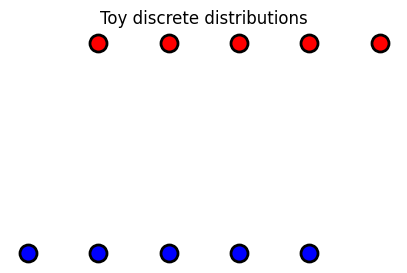

In [6]:
plt.figure(figsize=(5,3))
plt.title("Toy discrete distributions")
plot_distrib(x_toy, y_toy, a_toy, b_toy)

### Complex example

In [7]:
N = [150,100]
d=2

thetax = np.pi*np.random.rand(N[0], 1)
rx = .8 + .2*np.random.rand(N[0], 1)
thetay = -np.pi*np.random.rand(N[1], 1)
ry = .8 + .2*np.random.rand(N[1], 1)

x = np.hstack((np.cos(thetax)*rx + 0.5, np.sin(thetax)*rx))
y = np.hstack((np.cos(thetay)*ry - 0.5, np.sin(thetay)*ry))

In [8]:
normalize = lambda a: a/np.sum(a)
a = normalize(1.+np.random.rand(N[0]))
b = normalize(1.+np.random.rand(N[1]))

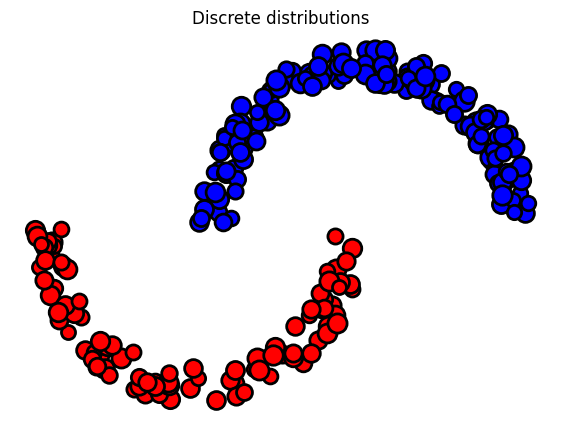

In [9]:
plt.figure(figsize=(7,5))
plt.title("Discrete distributions")
plot_distrib(x, y, a, b)

## 1.1 Computing OT by solving the primal :

In [10]:
def compute_cost(x, y):
    x_tile = np.tile(x[:, np.newaxis], (len(y), 1))
    y_tile = np.tile(y[:, np.newaxis], (len(x), 1)).transpose((1,0,2))
    C = np.sum(np.square(x_tile-y_tile), axis=2)
    return C

### Toy example :

In [11]:
C_toy = compute_cost(x_toy, y_toy)
P_toy = cp.Variable((5,5))

u = np.ones(5)
v = np.ones(5)
U = [0 <= P_toy, cp.matmul(P_toy,u)==a_toy, cp.matmul(P_toy.T,v)==b_toy]

objective = cp.Minimize(cp.sum(cp.multiply(P_toy,C_toy)))
prob = cp.Problem(objective, U)
result = prob.solve()

P_toy_OT = P_toy.value

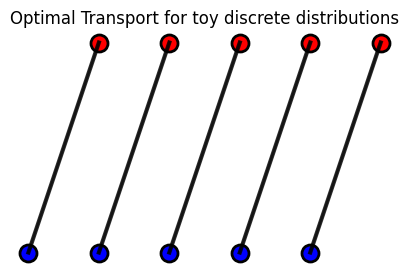

In [16]:
plt.figure(figsize=(5,3))
plt.title("Optimal Transport for toy discrete distributions")
plot_P(P_toy_OT, x_toy, y_toy, a_toy, b_toy)

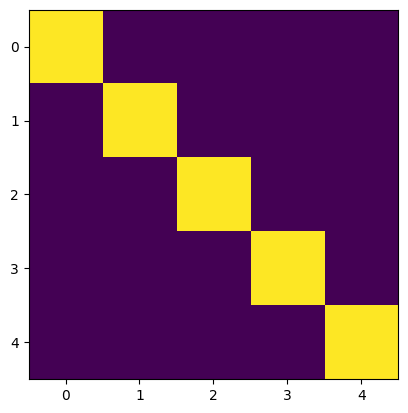

In [13]:
plt.imshow(P_toy_OT)
plt.show()

### Complex data :

In [14]:
C = compute_cost(x, y)
P = cp.Variable(N)

u = np.ones(N[1])
v = np.ones(N[0])
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]

objective = cp.Minimize(cp.sum(cp.multiply(P,C)))
prob = cp.Problem(objective, U)
result = prob.solve()

P_OT = P.value

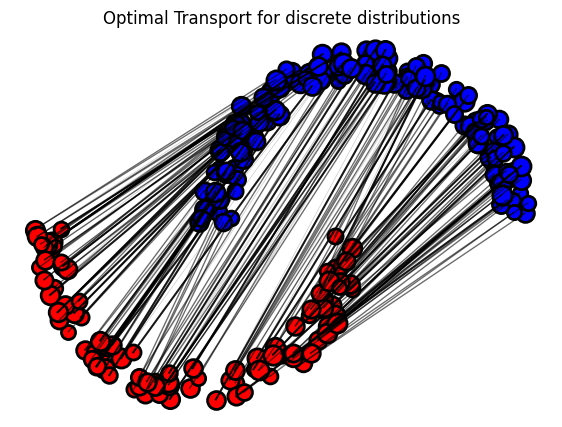

In [15]:
plt.figure(figsize=(7, 5))
plt.title("Optimal Transport for discrete distributions")
plot_P(P_OT, x, y, a, b, bold=0.5)

## 1.2 Computing $OT$ with SAG-OT :

In [32]:
def Xi(Ci, v):
    Xi = np.zeros_like(v)
    Xi[np.argmin(Ci-v)] = 1
    return Xi

def Grad_h(C, i, v, b):
    return b - Xi(C[i], v)

def v_c(C, v):
    I, J = C.shape
    return np.min(C - np.repeat(v.reshape(-1,1), I, axis=1).transpose(), axis=1)

def P_from_u_v(u, v, C, a, b, eps):
    I, J = C.shape
    u_tile = np.tile(u[:, np.newaxis], (1, J))
    a_tile = np.tile(a[:, np.newaxis], (1, J))
    v_tile = np.tile(v, (I,1))
    b_tile = np.tile(b, (I,1))
    return np.multiply(np.exp((u_tile + v_tile - C)/eps), np.multiply(a_tile, b_tile))

def SAG_OT(C, a, b, n_iter, step_size, figure=True):
    """
    Function to use when eps=0
    """
    I, J = C.shape
    v = np.zeros(J)
    mean_grad = np.zeros(J)
    g = np.zeros((I, J))

    grad_norm = np.zeros(n_iter)
    v_seq = np.zeros((n_iter, J))
    for k in range(n_iter):
        i = np.random.randint(I)
        mean_grad -= g[i]
        g[i] = a[i]*Grad_h(C, i, v, b)
        mean_grad += g[i]
        v += step_size*mean_grad

        grad_norm[k] = np.linalg.norm(mean_grad, ord=1)
        v_seq[k] = v
    
    if figure:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title(r"$||\sum_{i \in I}\nabla h_\epsilon(x_i,v)\mu_i||_1$")
        plt.plot(grad_norm)

        plt.subplot(122)
        plt.title(r"$||v - v^*||_1$")
        v_star = v_seq[-1]
        plt.plot(np.linalg.norm(v_seq-v_star, ord=1, axis=1)/np.linalg.norm(v_star, ord=1))
        plt.show()

    u = v_c(C, v)
    P = P_from_u_v(u, v, C, a, b, eps=0.01) #TODO
    return P

### Toy Example

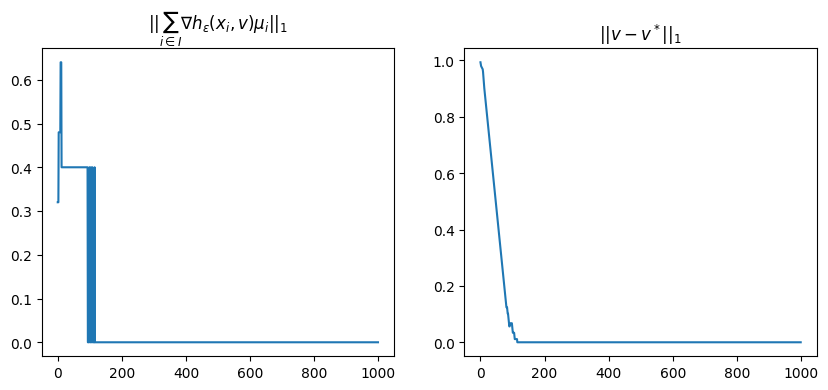

In [33]:
P_toy_SAG = SAG_OT(C_toy, a_toy, b_toy, n_iter=1000, step_size=0.05, figure=True)

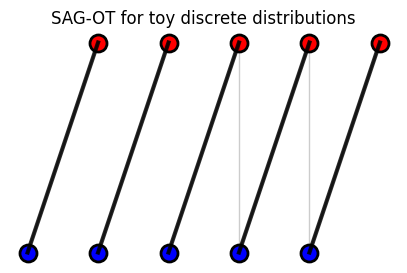

In [34]:
plt.figure(figsize=(5,3))
plt.title("SAG-OT for toy discrete distributions")
plot_P(P_toy_SAG, x_toy, y_toy, a_toy, b_toy)

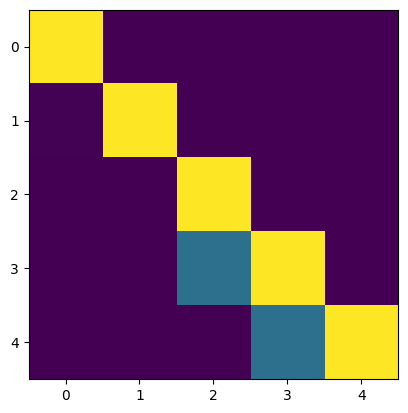

In [35]:
plt.imshow(P_toy_SAG)
plt.show()

### Complex Data

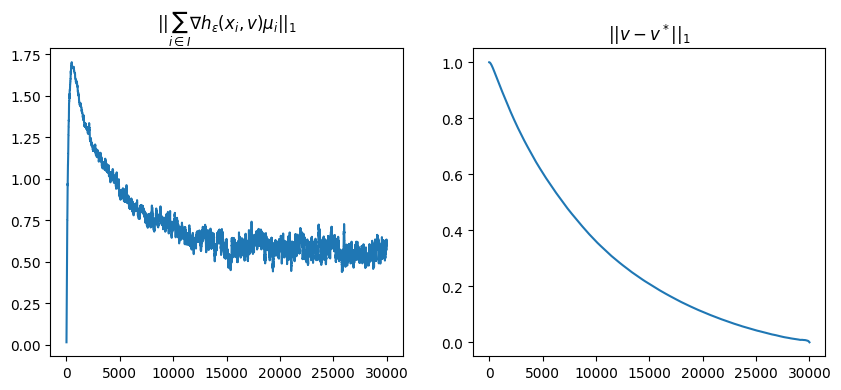

In [36]:
P_SAG = SAG_OT(C, a, b, n_iter=30000, step_size=0.01, figure=True)

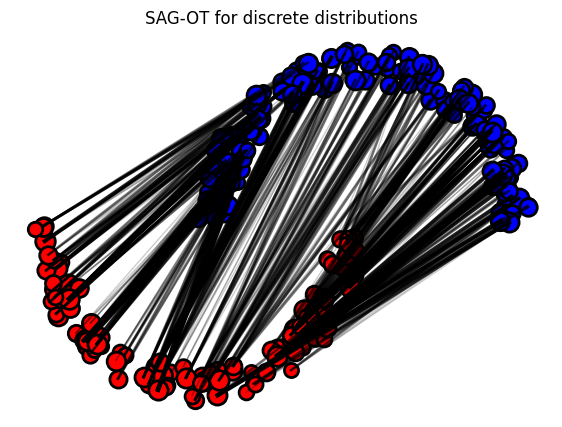

In [37]:
plt.figure(figsize=(7,5))
plt.title("SAG-OT for discrete distributions")
plot_P(P_SAG, x, y, a, b)

Results looks satisfying but open question : how to compute P from u and v when epsilon=0.

## 1.3 Computing $OT_\epsilon$ with Sinkhorn algorithm :

In [17]:
def Sinkhorn(C, a, b, eps, n_iter, figure=True):
    I, J = C.shape
    K = np.exp(-C/eps)
    v = np.ones(J)

    Err_p = np.zeros(n_iter)
    Err_q = np.zeros(n_iter)
    v_seq = np.zeros((n_iter, J))
    for k in range(n_iter):
        # Step 1:
        u = a / np.dot(K,v)
        Err_q[k] = np.linalg.norm(v*np.dot(np.transpose(K),u) - b, 1)
        # Step 2:
        v = b / np.dot(np.transpose(K),u)
        Err_p[k] = np.linalg.norm(u*np.dot(K,v) - a,1)

        v_seq[k] = v
    
    P_Sink = np.dot(np.dot(np.diag(u),K),np.diag(v))

    if figure:
        plt.figure(figsize = (10,4))
        plt.subplot(2,2,1)
        plt.title(r"$||P 1 - a||$")
        plt.plot(np.log(np.asarray(Err_p)), linewidth = 2)
        plt.subplot(2,2,3)
        plt.title(r"$||P^T 1 - b||$")
        plt.plot(np.log(np.asarray(Err_q)), linewidth = 2)
        
        plt.subplot(2,2,(2,4))
        plt.title(r"$||v - v^*||_1$")
        v_star = v_seq[-1]
        plt.plot(np.linalg.norm(v_seq-v_star, ord=1, axis=1)/np.linalg.norm(v_star, ord=1))
        
        plt.tight_layout()
        plt.show()

    return P_Sink

### Toy example

In [18]:
eps = .01

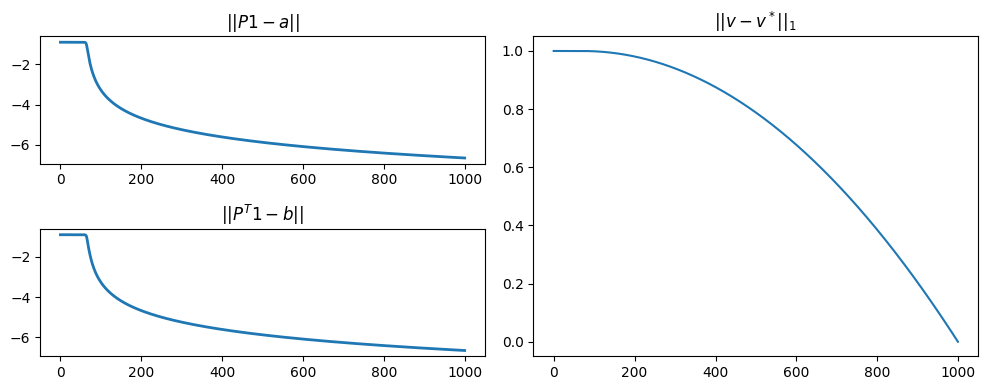

In [19]:
P_toy_Sink = Sinkhorn(C_toy, a_toy, b_toy, eps, n_iter=1000)

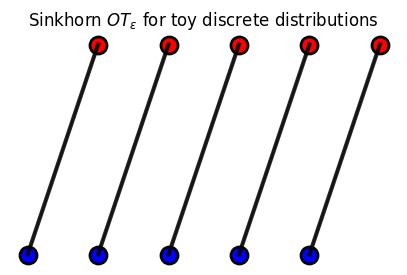

In [20]:
plt.figure(figsize=(5,3))
plt.title(r"Sinkhorn $OT_\epsilon$ for toy discrete distributions")
plot_P(P_toy_Sink, x_toy, y_toy, a_toy, b_toy)

### Complex data

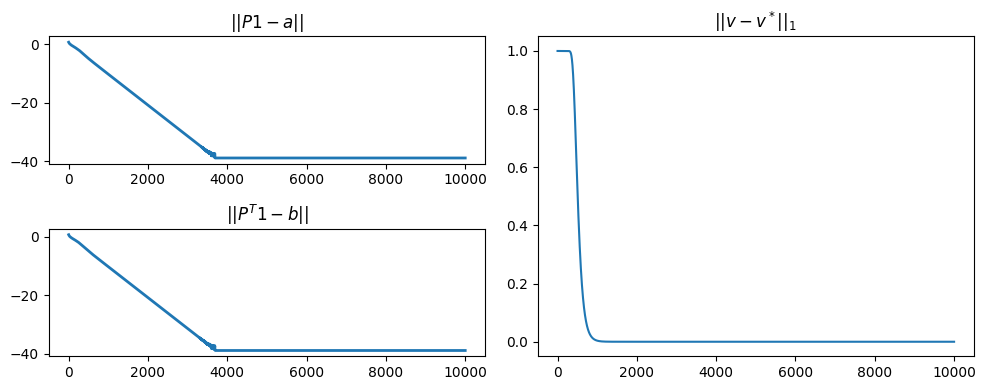

In [21]:
P_Sink = Sinkhorn(C, a, b, eps, n_iter=10000)

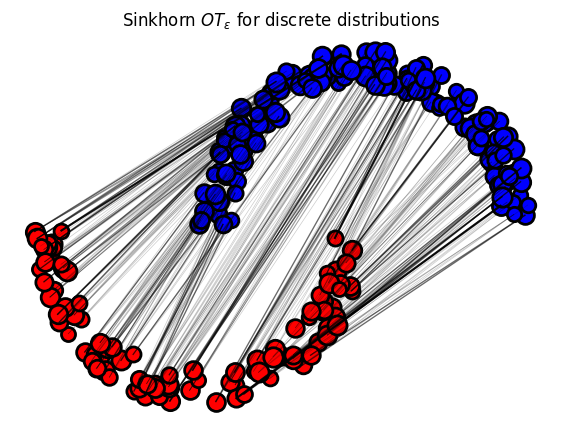

In [22]:
plt.figure(figsize=(7,5))
plt.title("Sinkhorn $OT_\epsilon$ for discrete distributions")
plot_P(P_Sink, x, y, a, b, bold=0.5)

## 1.4 Computing $OT_\epsilon$ with SAG-$OT_\epsilon$ :

In [23]:
def Xi_eps(r, b, eps):
    Xi = np.multiply(np.exp(-r/eps), b)
    return Xi / Xi.sum()

def Grad_h_eps(i, v, C, b, eps):
    return b - Xi_eps(C[i]-v, b, eps)

def v_c_eps(v, C, a, b, eps):
    I, J = C.shape
    u = np.zeros(I)
    for i in range(I):
        u[i] = -eps*np.log(np.dot(np.exp((v - C[i])/eps), b))
    return u

def P_from_u_v(u, v, C, a, b, eps):
    I, J = C.shape
    u_tile = np.tile(u[:, np.newaxis], (1, J))
    a_tile = np.tile(a[:, np.newaxis], (1, J))
    v_tile = np.tile(v, (I,1))
    b_tile = np.tile(b, (I,1))
    return np.multiply(np.exp((u_tile + v_tile - C)/eps), np.multiply(a_tile, b_tile))

def SAG_OT(C, a, b, eps, n_iter, step_size, figure=True):
    I, J = C.shape
    v = np.zeros(J)
    mean_grad = np.zeros(J)
    g = np.zeros((I, J))

    grad_norm = np.zeros(n_iter)
    v_seq = np.zeros((n_iter, J))
    for k in range(n_iter):
        i = np.random.randint(I)
        mean_grad -= g[i]
        g[i] = a[i]*Grad_h_eps(i, v, C, b, eps)
        mean_grad += g[i]
        v += step_size*mean_grad

        grad_norm[k] = np.linalg.norm(mean_grad, ord=1)
        v_seq[k] = v
    
    if figure:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title(r"$||\sum_{i \in I}\nabla h_\epsilon(x_i,v)\mu_i||_1$")
        plt.plot(grad_norm)

        plt.subplot(122)
        plt.title(r"$||v - v^*||_1$")
        v_star = v_seq[-1]
        plt.plot(np.linalg.norm(v_seq-v_star, ord=1, axis=1)/np.linalg.norm(v_star, ord=1))
        plt.show()

    u = v_c_eps(v, C, a, b, eps)
    P = P_from_u_v(u, v, C, a, b, eps)
    return P

### Toy example

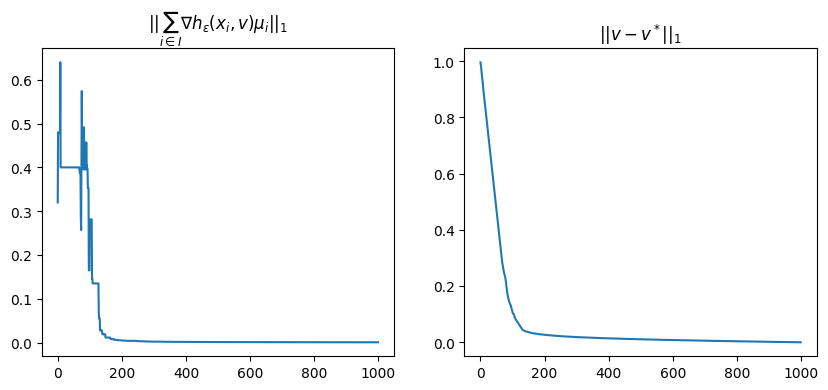

In [24]:
P_toy_SAG = SAG_OT(C_toy, a_toy, b_toy, eps, n_iter=1000, step_size=.05)

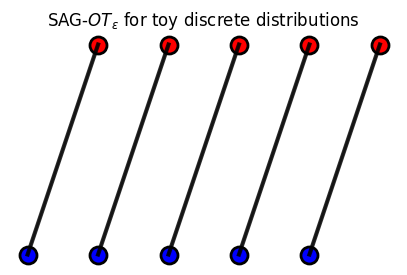

In [26]:
plt.figure(figsize=(5,3))
plt.title(r"SAG-$OT_\epsilon$ for toy discrete distributions")
plot_P(P_toy_SAG, x_toy, y_toy, a_toy, b_toy)

### Complex data

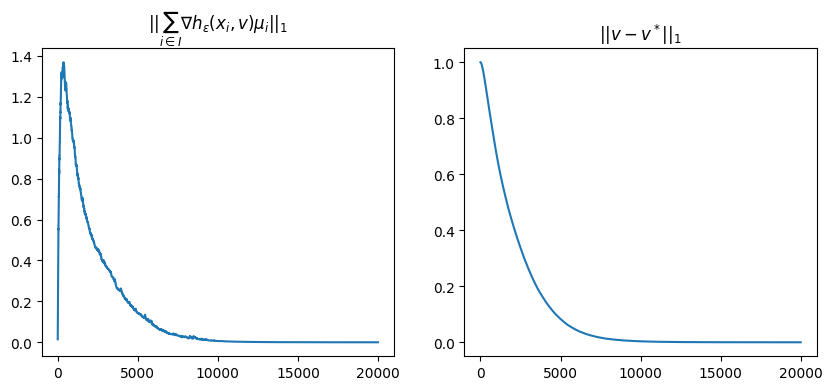

In [27]:
P_SAG = SAG_OT(C, a, b, eps, n_iter=20000, step_size=.05)

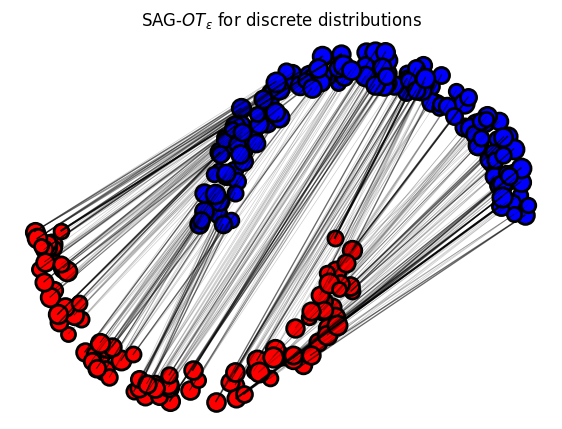

In [28]:
plt.figure(figsize=(7,5))
plt.title(r"SAG-$OT_\epsilon$ for discrete distributions")
plot_P(P_SAG, x, y, a, b, bold=0.5)

## 1.5 Results :

In [30]:
print(f"{np.linalg.norm(P_Sink-P_OT):.5f}")
print(f"{np.linalg.norm(P_SAG-P_OT):.5f}")
print(f"{np.linalg.norm(P_Sink-P_SAG):.5f}")

0.06159
0.06159
0.00000


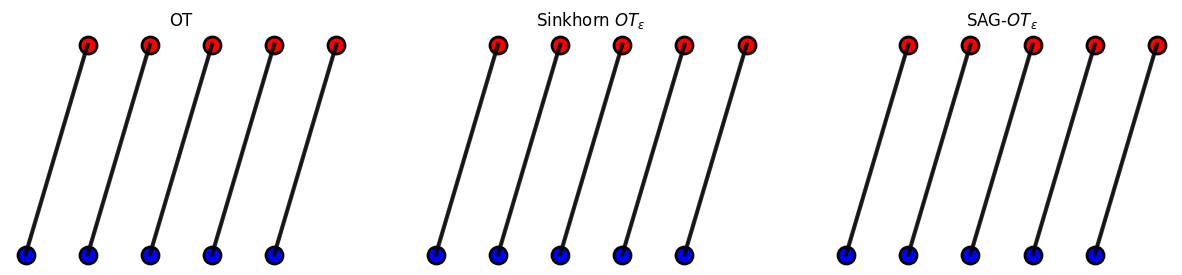

In [31]:
plt.figure(figsize=(15,3))

ax1 = plt.subplot(131)
ax1.set_title("OT")
plot_P(P_toy_OT, x_toy, y_toy, a_toy, b_toy)

ax2 = plt.subplot(132)
ax2.set_title(r"Sinkhorn $OT_\epsilon$")
plot_P(P_toy_Sink, x_toy, y_toy, a_toy, b_toy)

ax3 = plt.subplot(133)
ax3.set_title(r"SAG-$OT_\epsilon$")
plot_P(P_toy_SAG, x_toy, y_toy, a_toy, b_toy)

plt.show()

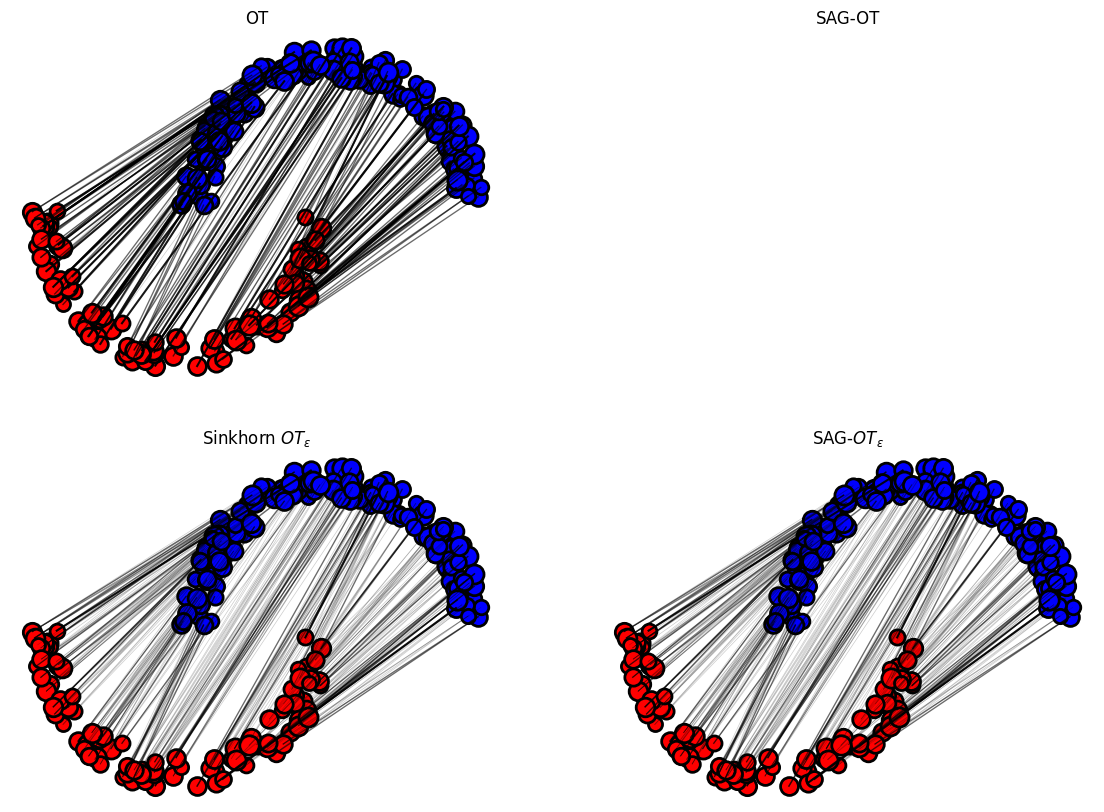

In [35]:
bold=0.5

plt.figure(figsize=(14,10))

ax1 = plt.subplot(221)
ax1.set_title("OT")
plot_P(P_OT, x, y, a, b, bold)

ax2 = plt.subplot(222)
ax2.set_title("SAG-OT")
#plot_P(P_SAG, x, y, a, b, bold)
plt.axis("off")

ax3 = plt.subplot(223)
ax3.set_title(r"Sinkhorn $OT_\epsilon$")
plot_P(P_Sink, x, y, a, b, bold)

ax4 = plt.subplot(224)
ax4.set_title(r"SAG-$OT_\epsilon$")
plot_P(P_SAG, x, y, a, b, bold)

plt.show()

We observe that the regularized solution is slightly less sparse. We see the effect of the regularization term.

# 2. Discrete - Continuous case :

In [82]:
#TODO SPLIT INTO REGULARIZED / NON REGULARIZED.

## 2.1 Generating the data

### Toy example

In [76]:
def Uniform(x):
    return 10* np.array((x[:,0]<0.2) * (x[:,0]>0.1) * (x[:,1]<1) * (x[:,1]>0))

In [77]:
y = np.array([[1, 1], [1, 0]])

In [78]:
p = 300  # size of the image for sampling, m=p*p
t = np.linspace(0, 1, p)
[V, U] = np.meshgrid(t, t)
grid = np.stack((U.flatten(), V.flatten())).transpose()

In [81]:
a = Uniform(grid)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

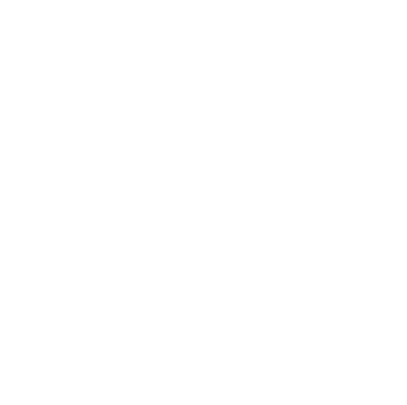

In [83]:
plt.figure(figsize = (5,5))
plt.axis("off")

plt.imshow(-a[::-1, :], extent=[0, 1, 0, 1], cmap='gray')
for i in range(len(b)):
    myplot(y[i, 0], y[i, 1], b[i]*len(b)*10, 'r')
plt.show()

### Complex example

In [76]:
N = 100
y = np.hstack((np.ones(N)[:, np.newaxis]*0.2, np.random.uniform(0.2, 0.8, N)[:, np.newaxis]))
b = np.ones(N)/N

In [77]:
p = 300  # size of the image for sampling, m=p*p
t = np.linspace(0, 1, p)
[V, U] = np.meshgrid(t, t)
Y = np.concatenate((U.flatten()[None, :], V.flatten()[None, :]))

In [78]:
def Gauss(mx, my, s): return np.exp((-(U-mx)**2-(V-my)**2)/(2*s**2))

Mx = .5
My = .8
s = .1
a = Gauss(Mx, My, s)
a = a/np.sum(a.flatten())

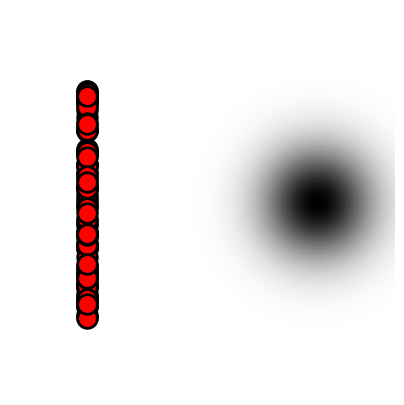

In [79]:
plt.figure(figsize = (5,5))
plt.axis("off")

plt.imshow(-a[::-1, :], extent=[0, 1, 0, 1], cmap='gray')
for i in range(len(b)):
    myplot(y[i, 0], y[i, 1], b[i]*len(b)*10, 'r')
plt.show()

In [80]:
def cost_SGD(x, y):
    return np.sum(np.square(y-x), axis=-1)

def Xi_SGD(r, nu, eps):
    Xi = np.multiply(np.exp(-r/eps), nu)
    return Xi / Xi.sum()

def grad_SGD(x, y, v, nu, eps):
    c_xy = np.array([cost_SGD(x, y[i]) for i in range(len(y))])
    
    return nu - Xi_SGD(c_xy-v, nu, eps)

In [81]:
def Averaged_SGD(y, nu, eps, steps, step_size):

    J = len(y)

    mu_mean = np.array([.8, .5])
    mu_sigma =  0.1

    samples = np.zeros((steps, J))

    v_tilda = np.zeros(J)
    v = v_tilda.copy()
    for k in range(steps):
        x_k = np.random.normal(mu_mean, mu_sigma)
        v_tilda += grad_SGD(x_k, y, v_tilda, nu, eps)*step_size/np.sqrt(k+1)
        v = v_tilda/(k+1) + v*k/steps
        samples[k] = v
    return samples

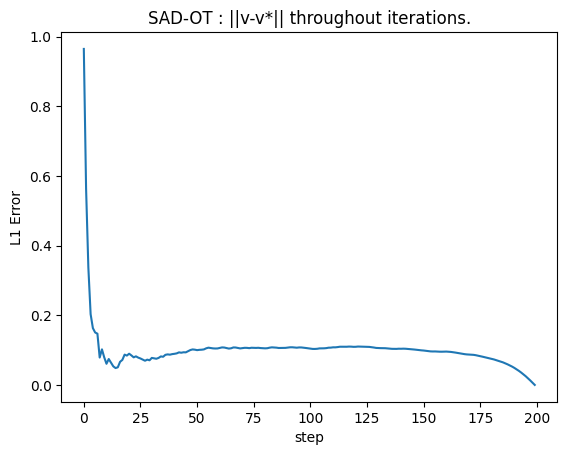

In [88]:
samples = Averaged_SGD(y, b, eps, 200, 1)
v_semi_discrete = samples[-1]

plt.plot(range(len(samples)), np.linalg.norm(samples-v_semi_discrete, ord=1, axis=1))
plt.title("SAD-OT : ||v-v*|| throughout iterations.")
plt.ylabel("L1 Error")
plt.xlabel("step")
plt.show()

We compare the results with the discrete-discrete version :

In [89]:
mu_mean = np.array([.8, .5])
mu_sigma =  .1
x = np.random.normal(mu_mean, mu_sigma, size=(200, 2))
a = np.ones(200)/200

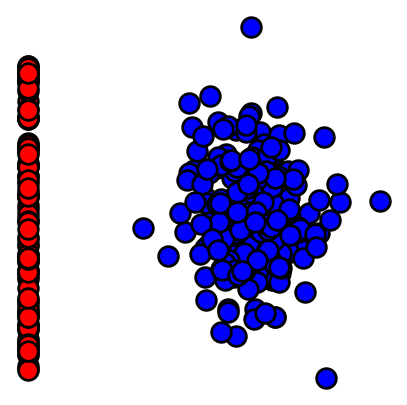

In [90]:
plt.figure(figsize = (5,5))
plt.axis("off")
for i in range(len(a)):
    myplot(x[i, 0], x[i, 1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(y[j, 0], y[j, 1], b[j]*len(b)*10, 'r')
plt.show()

In [91]:
x_large = np.tile(x[:, np.newaxis], (len(y), 1))
y_large = np.tile(y[:, np.newaxis], (len(x), 1)).transpose((1,0,2))
C = np.sum(np.square(x_large-y_large), axis=2)

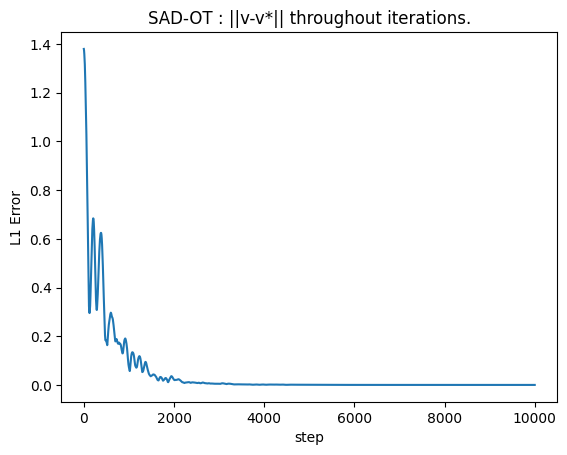

In [92]:
samples = SAG_OT(C, a, b, eps, steps=10000, step_size=0.1)
v_discrete = samples[-1]

plt.plot(range(len(samples)), np.linalg.norm(samples-v_discrete, ord=1, axis=1))
plt.title("SAD-OT : ||v-v*|| throughout iterations.")
plt.ylabel("L1 Error")
plt.xlabel("step")
plt.show()

In [93]:
u_discrete = eps_c_transform_v(C, a, b, v_discrete, eps)

I, J = C.shape
u_tile = np.tile(u_discrete[:, np.newaxis], (1, J))
a_tile = np.tile(a[:, np.newaxis], (1, J))
v_tile = np.tile(v_discrete, (I,1))
b_tile = np.tile(b, (I,1))

P_discrete = np.multiply(np.exp((u_tile + v_tile - C)/eps), np.multiply(a_tile, b_tile))

In [94]:
u_semi_discrete = eps_c_transform_v(C, a, b, v_semi_discrete, eps)

In [95]:
I, J = C.shape
u_tile = np.tile(u_semi_discrete[:, np.newaxis], (1, J))
a_tile = np.tile(a[:, np.newaxis], (1, J))
v_tile = np.tile(v_semi_discrete, (I,1))
b_tile = np.tile(b, (I,1))

P_semi_discrete = np.multiply(np.exp((u_tile + v_tile - C)/eps), np.multiply(a_tile, b_tile))

In [96]:
P_semi_discrete[:4, :4]

array([[7.04075184e-08, 1.64653616e-04, 6.29906167e-05, 1.57032481e-04],
       [1.56832428e-06, 1.34140462e-04, 1.47635402e-04, 1.48252971e-04],
       [4.34654694e-05, 2.17797164e-05, 1.23782049e-04, 3.02666161e-05],
       [4.77110829e-05, 1.93677820e-05, 1.17731799e-04, 2.71685490e-05]])

In [97]:
P_discrete[:4, :4]

array([[1.19180806e-08, 6.26625536e-05, 7.17706554e-06, 4.79424119e-05],
       [6.06647028e-07, 1.16656662e-04, 3.84392133e-05, 1.03430047e-04],
       [5.31378426e-05, 5.98633892e-05, 1.01859369e-04, 6.67369752e-05],
       [5.91558269e-05, 5.39892979e-05, 9.82552601e-05, 6.07558088e-05]])

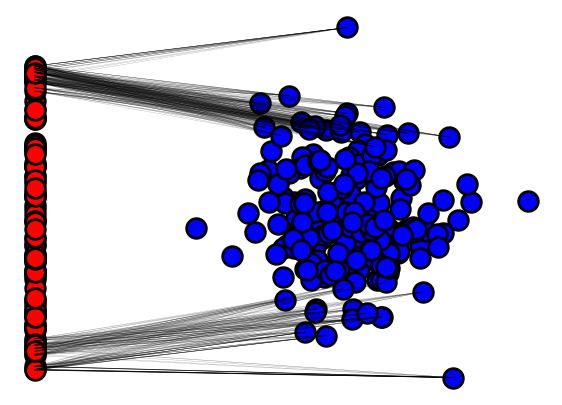

In [102]:
plot_P(P_discrete, x, y, bold=0.2)

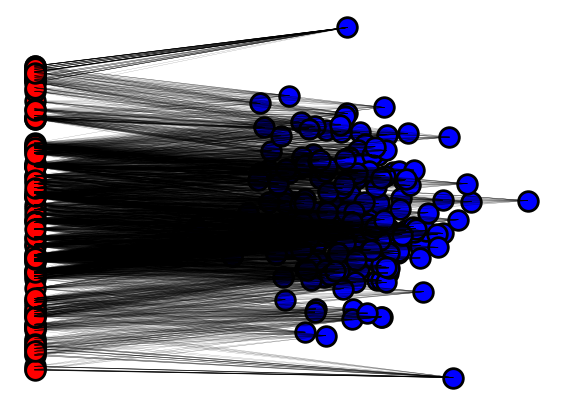

In [101]:
plot_P(P_semi_discrete, x, y, bold=0.2)

In [81]:
#TODO Use semi-discrete notebook to make nice vizualisation.

# 3. Continuous - Continuous case

Toy example : two gaussians, we know the optimal transport and can compute it in closed form. Can be re-written in the paper to add some content.

In [75]:
def kernel_SGD(c, kernel, mu, nu, eps, num_steps):
    step_size = 1e-2
    x, y, alpha = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

    x[0] = mu.rvs()
    y[0] = nu.rvs()
    alpha[0] = step_size * (1 - np.exp(-c(x[0], y[0])/eps))

    for k in range(1, num_steps):
        x[k] = mu.rvs()
        y[k] = nu.rvs()
        u = np.dot(alpha[:k], kernel(x[k], x[:k]))
        v = np.dot(alpha[:k], kernel(y[k], y[:k]))        
        alpha[k] = (step_size/np.sqrt(k+1)) * (1 - np.exp((u + v - c(x[k], y[k]))/eps))
    return alpha, x, y

In [76]:
def c(x, y):
    return np.square(x-y).mean()

In [77]:
#TODO make functionnal for d >= 2
def kernel(x, y, sigma=0.2):
    return np.exp(-np.square(x-y)/(sigma**2))

In [78]:
def approx_u(t, alpha, x):
    return np.dot(alpha, kernel(t, x))

def approx_v(t, alpha, y):
    return np.dot(alpha, kernel(t, y))

In [111]:
def continuous_wasserstein(mu, nu, c, eps, n_samples):
    alpha, x, y = kernel_SGD(c, kernel, mu, nu, eps, num_steps=int(1e4))
    
    samples_mu = mu.rvs(n_samples)
    samples_nu = nu.rvs(n_samples)

    w = 0
    for i in range(n_samples):
        u = approx_u(samples_mu[i], alpha, x)
        v = approx_v(samples_nu[i], alpha, y)
        w += u + v - eps*np.exp((u + v - c(samples_mu[i], samples_nu[i]))/eps)
    
    return w/n_samples

In [114]:
mu = norm(loc=0, scale=0.1)
nu = norm(loc=1, scale=0.1)

In [115]:
continuous_wasserstein(mu, nu, c, eps=0.1, n_samples=1000)

0.86688142879368

In [116]:
def bures_wasserstein(mu_mean, mu_sigma, nu_mean, nu_sigma):
    return np.square(mu_mean - nu_mean) + np.square(mu_sigma - nu_sigma)

In [117]:
start_mean = 0
start_sigma = 0.2

stop_mean = 4
stop_sigma = 0.2

nu = norm(loc=2, scale=0.2)

w_true = []
w_cont = []
num_steps = 50
for i in tqdm(range(num_steps+1)):
    mean = ((num_steps-i)*start_mean + i*stop_mean)/num_steps
    sigma = ((num_steps-i)*start_sigma + i*stop_sigma)/num_steps

    mu = norm(loc=mean, scale=sigma)

    w_true.append(bures_wasserstein(mean, sigma, 2, 0.2))
    w_cont.append(continuous_wasserstein(mu, nu, c, eps=0.1, n_samples=int(1e4)))

100%|██████████| 51/51 [03:42<00:00,  4.35s/it]


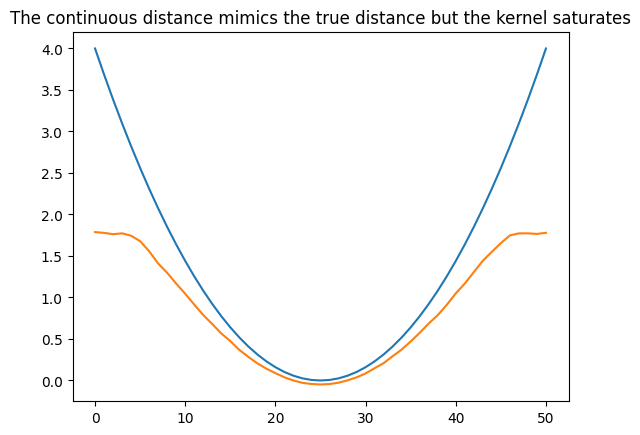

In [118]:
plt.title("The continuous distance mimics the true distance but the kernel saturates")
plt.plot(range(len(w_true)), w_true)
plt.plot(range(len(w_cont)), w_cont)
plt.show()

In [66]:
def plot_kernel_SGD(c, kernel, mu, nu, eps, num_steps):
    step_size = 1e-2
    x, y, alpha = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

    u_seq = np.zeros(num_steps)

    x[0] = mu.rvs()
    y[0] = nu.rvs()
    alpha[0] = step_size * (1 - np.exp(-c(x[0], y[0])/eps))

    for k in range(1, num_steps):
        x[k] = mu.rvs()
        y[k] = nu.rvs()
        u = np.dot(alpha[:k], kernel(x[k], x[:k]))
        v = np.dot(alpha[:k], kernel(y[k], y[:k]))        
        alpha[k] = (step_size/np.sqrt(k+1)) * (1 - np.exp((u + v - c(x[k], y[k]))/eps))
        u_seq[k] = u
    
    return u_seq

In [67]:
mu = norm(loc=1, scale=0.5)
nu = norm(loc=0, scale=0.5)

In [73]:
mu_nu_seq = plot_kernel_SGD(c, kernel, mu, nu, eps=0.1, num_steps=100)
mu_mu_seq = plot_kernel_SGD(c, kernel, mu, mu, eps=0.1, num_steps=100)
nu_nu_seq = plot_kernel_SGD(c, kernel, nu, nu, eps=0.1, num_steps=100)

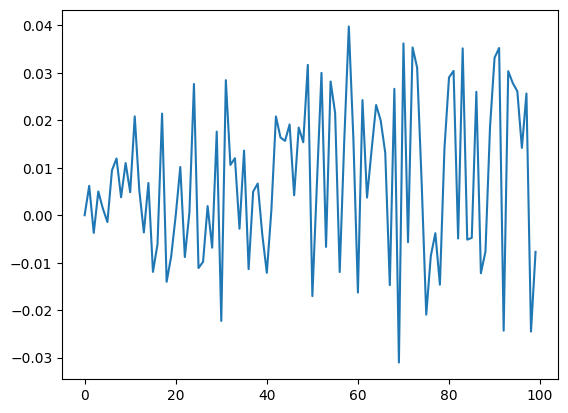

In [74]:
plt.plot(range(len(mu_nu_seq)), mu_nu_seq - 0.5*mu_mu_seq - 0.5*nu_nu_seq)
plt.show()